In [1]:
# =====================================
# STEP 0: Authenticate & Initialize Client
# =====================================
from google.colab import auth
from google.cloud import bigquery

auth.authenticate_user()

project_id = "etl-pipeline-436716"
client = bigquery.Client(project=project_id)


In [3]:
# =====================================
# STEP 1: Define Query
# =====================================
query = """
-- =========================================
-- Filtered Unified Patient Health Dataset (MIMIC-IV v3.1)
-- 10 target diseases, ~100K records total (balanced gender)
-- =========================================

-- Step 1: Demographics
WITH demographics AS (
  SELECT
    subject_id,
    gender,
    anchor_age AS age
  FROM `physionet-data.mimiciv_3_1_hosp.patients`
),

-- Step 2: Diagnoses (only target diseases)
diagnoses AS (
  SELECT
    d.subject_id,
    d.hadm_id,
    icd.long_title AS diagnosis_name
  FROM `physionet-data.mimiciv_3_1_hosp.diagnoses_icd` AS d
  LEFT JOIN `physionet-data.mimiciv_3_1_hosp.d_icd_diagnoses` AS icd
    ON d.icd_code = icd.icd_code
  WHERE icd.long_title IN (
    'Unspecified essential hypertension',
    'Anemia, unspecified',
    'Acute kidney failure, unspecified',
    'Congestive heart failure, unspecified',
    'Major depressive disorder, single episode, unspecified',
    'Anxiety disorder, unspecified',
    'Depressive disorder, not elsewhere classified',
    'Obesity, unspecified',
    'Hypothyroidism, unspecified',
    'Type 2 diabetes mellitus without complications'
  )
),

-- Step 3: Lab Results
lab_results AS (
  SELECT
    l.subject_id,
    l.hadm_id,
    dlab.label AS lab_test,
    l.valuenum AS lab_value,
    l.valueuom,
    l.charttime
  FROM `physionet-data.mimiciv_3_1_hosp.labevents` AS l
  JOIN `physionet-data.mimiciv_3_1_hosp.d_labitems` AS dlab
    ON l.itemid = dlab.itemid
  WHERE LOWER(dlab.label) IN (
    'glucose', 'creatinine', 'cholesterol', 'hemoglobin',
    'sodium', 'potassium', 'bilirubin', 'hematocrit', 'urea nitrogen'
  )
),

-- Step 4: Medications
medications AS (
  SELECT
    subject_id,
    hadm_id,
    STRING_AGG(DISTINCT drug, ', ') AS medications
  FROM `physionet-data.mimiciv_3_1_hosp.prescriptions`
  GROUP BY subject_id, hadm_id
),

-- Step 5: Procedures
procedures AS (
  SELECT
    subject_id,
    hadm_id,
    STRING_AGG(DISTINCT icd.long_title, ', ') AS procedures
  FROM `physionet-data.mimiciv_3_1_hosp.procedures_icd` AS p
  LEFT JOIN `physionet-data.mimiciv_3_1_hosp.d_icd_procedures` AS icd
    ON p.icd_code = icd.icd_code
  GROUP BY subject_id, hadm_id
),

-- Step 6: Notes (Discharge + Radiology)
notes AS (
  SELECT
    subject_id,
    hadm_id,
    charttime,
    text AS note_text
  FROM `physionet-data.mimiciv_note.discharge`
  UNION ALL
  SELECT
    subject_id,
    hadm_id,
    charttime,
    text AS note_text
  FROM `physionet-data.mimiciv_note.radiology`
),

-- Step 7: Combined data
combined AS (
  SELECT
    p.subject_id,
    p.gender,
    p.age,
    d.hadm_id,
    d.diagnosis_name,
    pr.procedures,
    m.medications,
    l.lab_test,
    l.lab_value,
    l.valueuom,
    l.charttime AS lab_time,
    n.note_text,
    n.charttime AS note_time
  FROM demographics AS p
  JOIN diagnoses AS d ON p.subject_id = d.subject_id
  LEFT JOIN procedures AS pr ON d.hadm_id = pr.hadm_id
  LEFT JOIN medications AS m ON d.hadm_id = m.hadm_id
  LEFT JOIN lab_results AS l ON d.hadm_id = l.hadm_id
  LEFT JOIN notes AS n ON d.hadm_id = n.hadm_id
),

-- Step 8: Balanced sampling
male_sample AS (
  SELECT *
  FROM combined
  WHERE UPPER(gender) = 'M'
  ORDER BY RAND()
  LIMIT 50000
),
female_sample AS (
  SELECT *
  FROM combined
  WHERE UPPER(gender) = 'F'
  ORDER BY RAND()
  LIMIT 50000
)

-- Step 9: Combine samples (males first)
SELECT *
FROM male_sample
UNION ALL
SELECT *
FROM female_sample
ORDER BY gender DESC, subject_id, lab_time
"""


In [4]:
# =====================================
# STEP 2: Run Query and Load into DataFrame
# =====================================

df = client.query(query).to_dataframe()

In [6]:
# === Save current dataframe to CSV and reload ===
import os
import pandas as pd


csv_path = "/content/mimic_filtered.csv"
df.to_csv(csv_path, index=False)
print("Saved CSV to", csv_path)

Saved CSV to /content/mimic_filtered.csv


In [7]:
# reload to ensure that the save/load works
df = pd.read_csv(csv_path, parse_dates=['lab_time', 'note_time'], infer_datetime_format=True, low_memory=False)
print("Reloaded CSV. shape:", df.shape)
df.head()

/tmp/ipython-input-1878276822.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(csv_path, parse_dates=['lab_time', 'note_time'], infer_datetime_format=True, low_memory=False)


Reloaded CSV. shape: (100000, 13)


,subject_id,gender,age,hadm_id,diagnosis_name,procedures,medications,lab_test,lab_value,valueuom,lab_time,note_text,note_time
0,10003019,M,69,22774359,"Depressive disorder, not elsewhere classified",Insertion of totally implantable vascular acce...,"0.9% Sodium Chloride, 5% Dextrose, 0.9% Sodium...",Sodium,140.0,mEq/L,2175-10-16 06:30:00,HISTORY: Please place double lumen port for c...,2175-10-13 12:24:00
1,10003019,M,69,20277210,"Depressive disorder, not elsewhere classified",Injection or infusion of cancer chemotherapeut...,"Sodium Chloride 0.9% Flush, Heparin Flush (10...",Hematocrit,28.2,%,2175-11-15 09:35:00,\nName: ___. Unit No: ___\n \...,2175-11-15 00:00:00
2,10003019,M,69,20962108,"Depressive disorder, not elsewhere classified","Venous catheterization, not elsewhere classified","Bag, Sodium Chloride 0.9% Flush, Heparin, Iso...",Creatinine,0.7,mg/dL,2176-01-13 00:01:00,"CHEST, TWO VIEWS: ___.\n\nHISTORY: ___ male ...",2176-01-06 12:00:00
3,10003637,M,57,28317408,"Acute kidney failure, unspecified","Insertion of Endotracheal Airway into Trachea,...","Sodium Chloride 0.9% Flush for CRRT, Soln, Ac...",Potassium,4.6,mEq/L,2150-05-18 01:55:00,NaN,NaT
4,10004235,M,47,24181354,"Congestive heart failure, unspecified",Continuous invasive mechanical ventilation for...,"Fentanyl Citrate, Tobramycin Sulfate, Lactated...",Sodium,133.0,mEq/L,2196-02-26 14:21:00,EXAMINATION: CT C-SPINE W/O CONTRAST\n\nINDIC...,2196-02-24 13:45:00


In [8]:
# === Quick EDA: demographics & labs ===
import numpy as np

print("\n--- Basic info ---")
print(df[['subject_id','gender','age','diagnosis_name']].head())
print("\nValue counts: gender")
print(df['gender'].value_counts(dropna=False))
print("\nAge stats:")
print(df['age'].describe())

# missingness per column
print("\nMissingness (percent):")
print((df.isna().mean()*100).round(2))

# top lab tests
print("\nTop lab tests:")
print(df['lab_test'].value_counts().head(20))

# distribution of diagnosis classes
print("\nDiagnosis counts (top):")
print(df['diagnosis_name'].value_counts())


--- Basic info ---
   subject_id gender  age                                 diagnosis_name
0    10003019      M   69  Depressive disorder, not elsewhere classified
1    10003019      M   69  Depressive disorder, not elsewhere classified
2    10003019      M   69  Depressive disorder, not elsewhere classified
3    10003637      M   57              Acute kidney failure, unspecified
4    10004235      M   47          Congestive heart failure, unspecified

Value counts: gender
gender
M    50000
F    50000
Name: count, dtype: int64

Age stats:
count    100000.000000
mean         63.286630
std          15.263495
min          18.000000
25%          54.000000
50%          64.000000
75%          74.000000
max          91.000000
Name: age, dtype: float64

Missingness (percent):
subject_id        0.00
gender            0.00
age               0.00
hadm_id           0.00
diagnosis_name    0.00
procedures        7.91
medications       0.14
lab_test          0.03
lab_value         2.62
valueuom    

In [18]:
import pandas as pd
import numpy as np
from pint import UnitRegistry

# ------------------------------
# Load your dataset
# ------------------------------
df = pd.read_csv(csv_path, parse_dates=['lab_time', 'note_time'], infer_datetime_format=True, low_memory=False)

# ------------------------------
# Initialize Pint for unit conversions
# ------------------------------
ureg = UnitRegistry()
Q_ = ureg.Quantity

# ------------------------------
# 1. STANDARDIZE DEMOGRAPHICS
# ------------------------------
# Standardize gender to 'M' / 'F'
df['gender'] = df['gender'].str.upper().replace({'MALE': 'M', 'FEMALE': 'F'})

# ------------------------------
# 2. FILL MISSING PROCEDURES & MEDICATIONS
# ------------------------------
df['procedures'] = df['procedures'].fillna("Unknown")
df['medications'] = df['medications'].fillna("Unknown")

# ------------------------------
# 3. FILL MISSING NOTES & NOTE TIME
# ------------------------------
df['note_text'] = df['note_text'].fillna("")
df['note_time'] = df['note_time'].fillna(df['lab_time'])  # fallback to lab timestamp

# ------------------------------
# 4. LAB VALUE & UNIT HANDLING
# ------------------------------

# Fill missing lab units based on lab_test defaults safely
def fill_unit(row):
    if pd.isna(row['valueuom']):
        if pd.notna(row['lab_test']):
            return default_units.get(row['lab_test'].lower(), 'count')
        else:
            return 'count'  # fallback if lab_test itself is missing
    else:
        return row['valueuom']

df['valueuom'] = df.apply(fill_unit, axis=1)

# Optionally, drop rows where lab_test is missing since they can't be normalized
df = df[df['lab_test'].notna()]

# Impute missing lab_value with median per lab_test
df['lab_value'] = df.groupby('lab_test')['lab_value'].transform(
    lambda x: x.fillna(x.median())
)

# Automatic unit normalization using Pint
def auto_normalize(row):
    val = row['lab_value']
    unit = str(row['valueuom']).strip()
    test = str(row['lab_test']).strip().lower()

    if pd.isna(val) or val == "":
        return np.nan

    try:
        target_units = {
            'glucose': 'mg/dL',
            'creatinine': 'µmol/L',
            'bilirubin': 'µmol/L',
            'potassium': 'mmol/L',
            'sodium': 'mmol/L',
            'hemoglobin': 'g/dL',
            'hematocrit': '%',
            'urea nitrogen': 'mg/dL',
            'cholesterol': 'mg/dL'
        }
        if test in target_units:
            target = target_units[test]
            q = Q_(val, unit)
            normalized = q.to(target)
            row['lab_value'] = normalized.magnitude
            row['valueuom'] = target
            return row['lab_value']
        else:
            return val
    except Exception:
        return val

df['lab_value'] = df.apply(auto_normalize, axis=1)

# Drop any remaining rows with missing critical numeric lab values
df = df.dropna(subset=['lab_value'])

# ------------------------------
# 5. FINAL CHECKS
# ------------------------------
print("✅ Final missingness per column (%):")
print(df.isna().mean() * 100)

df.to_csv("mimic_final_cleaned.csv", index=False)
print("Final cleaned dataset saved as mimic_final_cleaned.csv")

/tmp/ipython-input-2253884133.py:8: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(csv_path, parse_dates=['lab_time', 'note_time'], infer_datetime_format=True, low_memory=False)


✅ Final missingness per column (%):
subject_id        0.0
gender            0.0
age               0.0
hadm_id           0.0
diagnosis_name    0.0
procedures        0.0
medications       0.0
lab_test          0.0
lab_value         0.0
valueuom          0.0
lab_time          0.0
note_text         0.0
note_time         0.0
dtype: float64
Final cleaned dataset saved as mimic_final_cleaned.csv


*Prepare Features*

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np

# Load cleaned data
df = pd.read_csv("mimic_final_cleaned.csv", parse_dates=['lab_time', 'note_time'])

# ------------------------------
# Target variable
# ------------------------------
y = df['diagnosis_name']
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # 0-9 for 10 diseases

# ------------------------------
# Feature Engineering: Aggregate Labs
# ------------------------------
# Compute mean lab values per subject_id + hadm_id
lab_summary = df.groupby(['subject_id', 'hadm_id', 'lab_test'])['lab_value'].agg(['mean', 'min', 'max']).reset_index()
lab_pivot = lab_summary.pivot_table(index=['subject_id','hadm_id'],
                                    columns='lab_test',
                                    values=['mean','min','max'])
# Flatten MultiIndex columns
lab_pivot.columns = ['_'.join(col).strip() for col in lab_pivot.columns.values]
lab_pivot = lab_pivot.reset_index()

# Merge demographics + procedures + medications
demo_proc_med = df[['subject_id','hadm_id','age','gender','procedures','medications']].drop_duplicates()
X = pd.merge(demo_proc_med, lab_pivot, on=['subject_id','hadm_id'], how='left')

# For simplicity, assign the first diagnosis per patient admission as target
y = df[['subject_id','hadm_id','diagnosis_name']].drop_duplicates(subset=['subject_id','hadm_id'])
Xy = pd.merge(X, y, on=['subject_id','hadm_id'], how='inner')

# Separate features and target
y_encoded = LabelEncoder().fit_transform(Xy['diagnosis_name'])
X_final = Xy.drop(['subject_id','hadm_id','diagnosis_name'], axis=1)

# ------------------------------
# Preprocessing: Categorical encoding
# ------------------------------
categorical_features = ['gender','procedures','medications']
numeric_features = [col for col in X.columns if col not in categorical_features + ['subject_id','hadm_id']]

# One-hot encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ], remainder='passthrough'
)


# 1️⃣ Fill missing numeric features
numeric_features = X_final.select_dtypes(include=np.number).columns
X_final[numeric_features] = X_final[numeric_features].fillna(X_final[numeric_features].median())

# 2️⃣ Fill missing categorical features
categorical_features = ['gender', 'procedures', 'medications']
X_final[categorical_features] = X_final[categorical_features].fillna('Unknown')

# ------------------------------
# 3️⃣ Train-test split
# ------------------------------
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

In [24]:
# Logistic Regression
logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, multi_class='multinomial'))
])

# Train
logreg_pipeline.fit(X_train, y_train)

# Predict
y_pred_lr = logreg_pipeline.predict(X_test)
y_prob_lr = logreg_pipeline.predict_proba(X_test)

# Metrics
f1_lr = f1_score(y_test, y_pred_lr, average='macro')
auroc_lr = roc_auc_score(y_test, y_prob_lr, multi_class='ovr', average='macro')

print(f"Logistic Regression - F1 (macro): {f1_lr:.4f}")
print(f"Logistic Regression - AUROC (macro): {auroc_lr:.4f}")


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression - F1 (macro): 0.0879
Logistic Regression - AUROC (macro): 0.6059


In [25]:
# Random Forest
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=200, random_state=42))
])

# Train
rf_pipeline.fit(X_train, y_train)

# Predict
y_pred_rf = rf_pipeline.predict(X_test)
y_prob_rf = rf_pipeline.predict_proba(X_test)

# Metrics
f1_rf = f1_score(y_test, y_pred_rf, average='macro')
auroc_rf = roc_auc_score(y_test, y_prob_rf, multi_class='ovr', average='macro')

print(f"Random Forest - F1 (macro): {f1_rf:.4f}")
print(f"Random Forest - AUROC (macro): {auroc_rf:.4f}")


Random Forest - F1 (macro): 0.1120
Random Forest - AUROC (macro): 0.5876


In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.impute import SimpleImputer
from scipy.sparse import hstack

# ------------------------------
# 1️⃣ Load cleaned dataset
# ------------------------------
csv_path = "mimic_final_cleaned.csv"
df = pd.read_csv(csv_path, parse_dates=['lab_time', 'note_time'], low_memory=False)

# ------------------------------
# 2️⃣ Aggregate lab tests per patient-admission
# ------------------------------
lab_agg = df.groupby(['subject_id','hadm_id','lab_test'])['lab_value'].agg(['mean','min','max']).reset_index()
lab_pivot = lab_agg.pivot_table(
    index=['subject_id','hadm_id'],
    columns='lab_test',
    values=['mean','min','max']
)
lab_pivot.columns = ['_'.join(col).strip() for col in lab_pivot.columns.values]
lab_pivot = lab_pivot.reset_index()

# ------------------------------
# 3️⃣ Aggregate labels per patient-admission
# ------------------------------
y_final = df.groupby(['subject_id','hadm_id'])['diagnosis_name'].first().reset_index()

# ------------------------------
# 4️⃣ Merge structured features + labs + labels
# ------------------------------
X_struct = df[['subject_id','hadm_id','gender','procedures','medications','note_text']].drop_duplicates(subset=['subject_id','hadm_id'])
X_final = pd.merge(X_struct, lab_pivot, on=['subject_id','hadm_id'], how='left')
X_final = pd.merge(X_final, y_final, on=['subject_id','hadm_id'], how='left')

# ------------------------------
# 5️⃣ Encode target labels
# ------------------------------
le = LabelEncoder()
y_encoded = le.fit_transform(X_final['diagnosis_name'])

# ------------------------------
# 6️⃣ Fill missing values and standardize
# ------------------------------
# Categorical features
categorical_features = ['gender','procedures','medications']
for col in categorical_features:
    X_final[col] = X_final[col].fillna('Unknown')

# Ensure note_text column exists
if 'note_text' not in X_final.columns:
    X_final['note_text'] = ""
X_final['note_text'] = X_final['note_text'].fillna("")

# Numeric features: fill median
numeric_features = X_final.select_dtypes(include=np.number).columns
X_final[numeric_features] = X_final[numeric_features].fillna(X_final[numeric_features].median())

# ------------------------------
# 7️⃣ Train-test split
# ------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_final.drop(['diagnosis_name'], axis=1),
    y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

# ------------------------------
# 8️⃣ Preprocessing pipelines
# ------------------------------
# Numeric transformer
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical transformer
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# ColumnTransformer
ct = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
], remainder='drop')

# TF-IDF for notes
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')

# ------------------------------
# 9️⃣ Apply preprocessing and combine features
# ------------------------------
X_train_struct = ct.fit_transform(X_train)
X_test_struct = ct.transform(X_test)

X_train_text = tfidf.fit_transform(X_train['note_text'])
X_test_text = tfidf.transform(X_test['note_text'])

X_train_combined = hstack([X_train_struct, X_train_text])
X_test_combined = hstack([X_test_struct, X_test_text])


In [29]:
# ------------------------------
# 9️⃣ Logistic Regression classifier
# ------------------------------
lr = LogisticRegression(
    max_iter=2000,
    class_weight='balanced',
    n_jobs=-1,
    solver='lbfgs',
    multi_class='multinomial'
)
lr.fit(X_train_combined, y_train)

y_pred_lr = lr.predict(X_test_combined)
y_prob_lr = lr.predict_proba(X_test_combined)

f1_lr = f1_score(y_test, y_pred_lr, average='macro')
auroc_lr = roc_auc_score(y_test, y_prob_lr, multi_class='ovr', average='macro')

print(f"Logistic Regression - F1 (macro): {f1_lr:.4f}")
print(f"Logistic Regression - AUROC (macro): {auroc_lr:.4f}")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression - F1 (macro): 0.2206
Logistic Regression - AUROC (macro): 0.7188


In [9]:
# ------------------------------
# 8️⃣ Random Forest classifier
# ------------------------------
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_combined, y_train)

y_pred_rf = rf.predict(X_test_combined)
y_prob_rf = rf.predict_proba(X_test_combined)

f1_rf = f1_score(y_test, y_pred_rf, average='macro')
auroc_rf = roc_auc_score(y_test, y_prob_rf, multi_class='ovr', average='macro')

print(f"Random Forest - F1 (macro): {f1_rf:.4f}")
print(f"Random Forest - AUROC (macro): {auroc_rf:.4f}")



Random Forest - F1 (macro): 0.1887
Random Forest - AUROC (macro): 0.7144


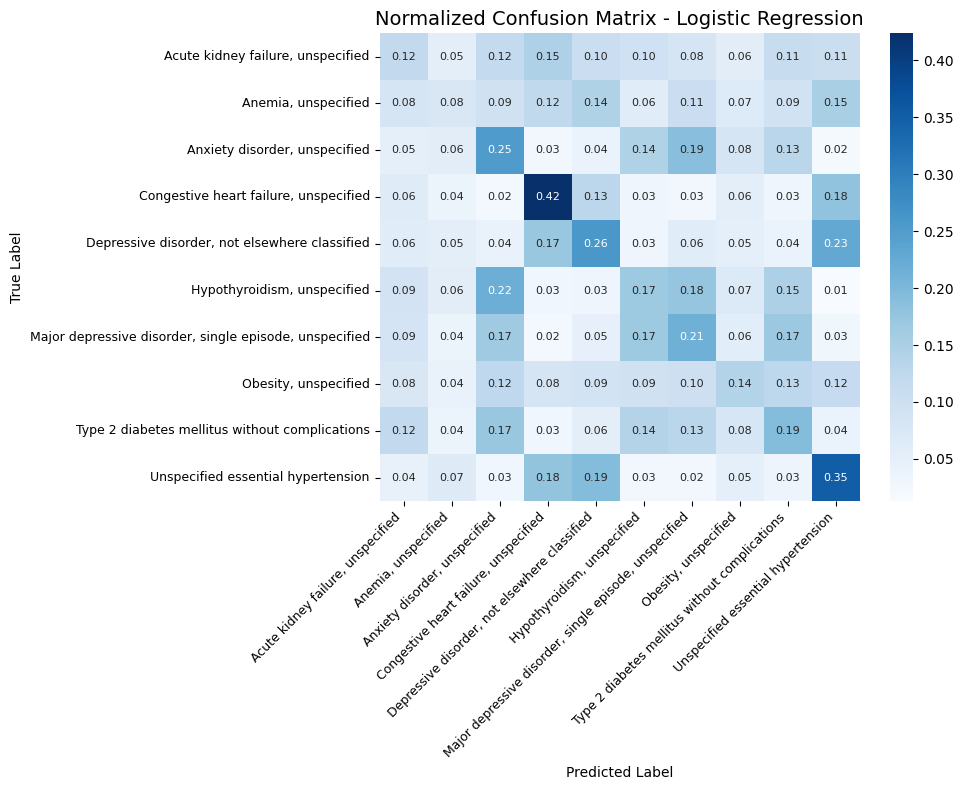

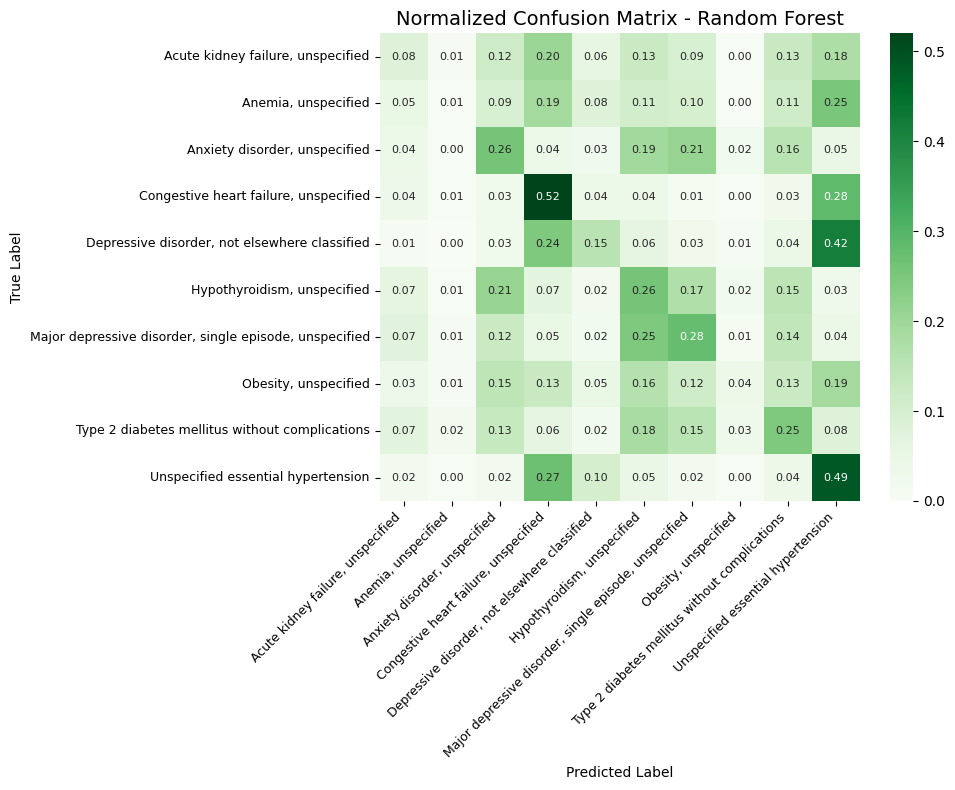

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# ------------------------------
# Logistic Regression Confusion Matrix
# ------------------------------
cm_lr = confusion_matrix(y_test, y_pred_lr, normalize='true')

plt.figure(figsize=(10, 8))
sns.heatmap(cm_lr, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_,
            annot_kws={"size": 8})  # <- control number font size
plt.title("Normalized Confusion Matrix - Logistic Regression", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(fontsize=9)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# ------------------------------
# Random Forest Confusion Matrix
# ------------------------------
cm_rf = confusion_matrix(y_test, y_pred_rf, normalize='true')

plt.figure(figsize=(10, 8))
sns.heatmap(cm_rf, annot=True, fmt=".2f", cmap="Greens",
            xticklabels=le.classes_, yticklabels=le.classes_,
            annot_kws={"size": 8})  # <- control number font size
plt.title("Normalized Confusion Matrix - Random Forest", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(fontsize=9)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()
